In [1]:
%%capture
!python3 -m pip install pandas numpy matplotlib tensorflow tqdm bs4 IP2Location

In [2]:
import requests
import urllib3
from urllib.parse import urlparse, urljoin
import socket

from bs4 import BeautifulSoup
import chardet
import re
import json

import math
import statistics

import os
import IP2Location

import pandas as pd
import numpy as np

from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow.keras import Sequential
import tensorflow.keras.layers
import tensorflow.keras.losses

from matplotlib import pyplot

from sklearn.model_selection import train_test_split, KFold

from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

import warnings
warnings.filterwarnings(action="ignore", module="urllib3")

2023-03-27 11:35:28.588106: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-27 11:35:28.588160: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
DOWNLOAD_CHUNK_SIZE = 0
TIMEOUT = (10, 10)
feature_names = ["words", "aux", "city", "region", "country", "redirects", "latitude", "longitude"]

In [4]:
ip2location_database = IP2Location.IP2Location()
ip2location_database.open(os.path.join("location_data", "IP2LOCATION-LITE-DB11.BIN"))
def get_location(ip_addr=None, hostname=None):
    if(ip_addr is None and hostname is not None):
        try:
            ip_addr = socket.gethostbyname(hostname)
        except socket.error:
            print("Skipped Location Download (Socket Error)")
            return None
    location_data = ip2location_database.get_all(ip_addr)
    if(location_data.country_short == "-"):
        if(not ip_addr in location_database):
            location_data = requests.get("https://ipinfo.io/"+ip_addr+"/json").json()
            if("error" in location_data):
                raise Exception("Failed because error with download (probably daily api quota exceded)")
            location_database[ip_addr] = location_data
            location_database[ip_addr]["country_short"] = location_data["country"]
            location_database[ip_addr]["latitude"], location_database[ip_addr]["longitude"] = tuple(location_data["loc"].split(","))
    else:
        return json.loads(str(location_data).replace("'", "\""))
    return location_database[ip_addr]

In [5]:
def get_absolute_url_from_relative(original_url, new_url):
    if(new_url.startswith("javascript")):
        return None
    if(new_url.startswith("http")):
        return new_url
    url_with_scheme = "http://"+original_url if not original_url.startswith("http") else original_url
    parsed_url = urlparse(url_with_scheme)
    url_scheme = parsed_url.scheme
    url_host = parsed_url.netloc
    
    return urljoin(url_scheme+"://"+url_host, new_url)

In [6]:
def download_aux_data(content, original_url):
    aux = []
    soup = BeautifulSoup(content, 'html.parser')
    for a in tqdm(soup.find_all('a')):
        href = a.get('href')
        if(href is not None):
            url = get_absolute_url_from_relative(original_url, href)
            if(url is not None):
                hostname = urlparse(url).netloc
                json = get_location(hostname=hostname)
                if(json is None):
                    continue
                try:
                    columns = [
                        "hostname_"+hostname,
                        "ip_addr_"+json["ip"],
                        "latitude_"+str(int(float(json["latitude"]))),
                        "longitude_"+str(int(float(json["longitude"]))),
                        "city_"+json["city"],
                        "region_"+json["region"],
                        "country_"+json["country_short"],
                    ]
                except KeyError:
                    print("Problem with JSON: ", json)
                    columns = []
                
                columns = [ re.compile('[\W_]+').sub('_', column) for column in columns ]
                
                aux = aux + columns
                
    return " ".join(aux)

In [7]:
def download_one(original_url, timeout=TIMEOUT):
    row = {}
    row["attempted_download"] = True

    url_with_scheme = "http://"+original_url if not original_url.startswith("http") else original_url
    parsed_url = urlparse(url_with_scheme)
    hostname = parsed_url.netloc
    
    try:
        row["hostname"] = hostname

        ip_addr = socket.gethostbyname(hostname)
        row["ip_addr"] = ip_addr

        r = requests.get(url_with_scheme, verify=False, timeout=timeout)

        row["status_code"] = r.status_code
        encoding = chardet.detect(r.content)['encoding']
        #if(encoding == None):
        #    print("Skipped content download (Decoding Error)")
        try:
            content = r.content.decode(encoding)
            row["content"] = content
        except:
            try:
                content = r.content.decode("utf")
            except:
                content = None
                print("Skipped content download (Decoding Error)")
            
        if(content is not None):
            row["aux"] = download_aux_data(content, original_url)
            row["words"] = " ".join(re.compile('[\W_]+').sub(' ', BeautifulSoup(content, 'html.parser').get_text()).split(" "))
        
        redirects = 0
        for r_history in r.history:
            if(r_history.status_code == 301):
                redirects = redirects + 1
        row["redirects"] = redirects

        json = get_location(ip_addr=ip_addr)
        if(json is None):
            return row
        try:
            row["latitude"] = json["latitude"]
            row["longitude"] = json["longitude"]
            row["city"] = json["city"]
            row["region"] = json["region"]
            row["country"] = json["country_short"]

        except KeyError:
            print("Problem with JSON: ", json)
        
            
        

    except socket.error:
        print("Skipped (Socket Error)")
        
    except UnicodeError:
        print("Skipped (Unicode Error)")
    
    return row

In [8]:
#raw_data.loc[raw_data[raw_data["attempted_download"] == True].index[-500:], "attempted_download"] = False
#raw_data
#raw_data.to_csv("./data.csv")

In [9]:
def download_chunk(chunk_size=DOWNLOAD_CHUNK_SIZE, timeout=TIMEOUT):
    global raw_data
    if(len(raw_data[raw_data["attempted_download"] == True].index) != 0):
          start = raw_data[raw_data["attempted_download"] == True].index[-1]+1
    end = start + chunk_size
    end = end if len(raw_data["url"]) > end else len(raw_data["url"])
    
    print("Downloading %d more rows ([%d:%d])" % (chunk_size, start, end))
    for row_index in tqdm(range(start, end)):
        row = download_one(raw_data.loc[row_index, "url"], timeout=timeout)
        if(len(list(row)) > 0):
            raw_data.loc[row_index, list(row)] = row.values()

In [10]:
def load_data():
    global raw_data, location_database
    
    raw_data = pd.read_csv("./raw_data.csv")
    raw_data["attempted_download"] = False
    
    try:
        with open("./location_data.json", 'r') as file:
            location_database = json.load(file)
        file.close()
    except FileNotFoundError:
        location_database = {}

    try:
        raw_data = pd.read_csv("./data.csv", index_col=0)
        if(DOWNLOAD_CHUNK_SIZE > 0):
            download_chunk()
            raw_data.to_csv("./data.csv")
            with open("./location_data.json", 'w') as file:
                json.dump(location_database, file)
            file.close()

    except FileNotFoundError:
        download_chunk()
        raw_data.to_csv("./data.csv")
        with open("./location_data.json", 'w') as file:
            json.dump(location_database, file)
        file.close()

    data = raw_data.copy()
    data = data.drop("attempted_download", axis=1)
    data = data[data["status_code"] == 200]
    data = data.drop("status_code", axis=1)
    data = data[feature_names + ["type"]].dropna()
    data = data.reset_index(drop=True)
    data["redirects"] = data["redirects"].astype(np.str)
    data["latitude"] = data["latitude"].astype(np.str)
    data["longitude"] = data["longitude"].astype(np.str)
    return data

In [11]:
# raw_data = pd.read_csv("./data.csv", index_col=0)
# loc = raw_data[raw_data["loc"].notna()]["loc"].str.split(",", expand=True)
# raw_data["latitude"] = loc[0]
# raw_data["longitude"] = loc[1]
# raw_data = raw_data.drop("loc", axis=1)
# raw_data.to_csv("./data.csv")

In [12]:
for i in range(1):
    data = load_data()
data

/tmp/ipykernel_215549/3493489388.py:2: DtypeWarning: Columns (4,5,7,9,10,11,12,13,14) have mixed types.Specify dtype option on import or set low_memory=False.
  data = load_data()


,words,aux,city,region,country,redirects,latitude,longitude,type
0,larcadelcarnevale com Buy this domain larcade...,hostname_secure_voodoo_com ip_addr_192_64_146_...,Munich,Bavaria,DE,0.0,48.1374,11.5755,defacement
1,Sorteo Notebook Diciembre 2012JavaScript isn t...,hostname_accounts_google_com ip_addr_142_251_1...,Washington,"Washington, D.C.",US,2.0,38.8951,-77.0364,phishing
2,Shopper s Heaven 인터파크 홈 리빙 세탁 청소용품 리빙 최신 등록순 ...,hostname_interpark_com ip_addr_211_233_74_23 l...,Seoul,Seoul,KR,0.0,37.566,126.9784,benign
3,Links KontaktAnfahrtDatenschutzImpressum Home...,hostname_www_pn_wuppertal_de ip_addr_217_160_0...,Karlsruhe,Baden-Wurttemberg,DE,1.0,49.0094,8.4044,defacement
4,AfterMarket pl domena parafiapiaski pl Domena...,hostname_www_aftermarket_pl ip_addr_185_253_21...,Warsaw,Mazovia,PL,0.0,52.2298,21.0118,defacement
...,...,...,...,...,...,...,...,...,...
461,Huamuxtitlan Huamuxtitlan Gro Saltar al conte...,hostname_huamuxtitlan_com ip_addr_107_180_25_1...,Ashburn,Virginia,US,1.0,39.039474,-77.491806,defacement
462,Citizendia Bandar Situs Slot Online Pragmatic...,hostname_citizendia_org ip_addr_172_67_212_189...,San Francisco,California,US,3.0,37.7757,-122.395203,benign
463,碎布头制作贴画教程图片展示 贴画网 树叶粘贴画 豆子粘贴画 剪贴画 拼贴画 布贴画 儿童贴...,hostname_www_9779_info ip_addr_160_153_63_37 l...,Tempe,Arizona,US,0.0,33.336079,-111.922157,malware
464,MONA MUR Vocalist Composer Audio Designer Sto...,hostname_monamur_com ip_addr_81_169_145_66 lat...,Berlin,Berlin,DE,1.0,52.524368,13.41053,benign


In [13]:
sl = tf.keras.layers.StringLookup(output_mode='one_hot')
sl.adapt(data["type"])

y = sl(list(data["type"]))

X_train, X_test, y_train, y_test = train_test_split(data[feature_names], y, test_size=0.10)

2023-03-27 11:35:36.213733: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-27 11:35:36.213792: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-27 11:35:36.213824: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (benjamin-XPS-13-9370): /proc/driver/nvidia/version does not exist
2023-03-27 11:35:36.214181: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-27 11:35:36.287016: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of th

In [14]:
max_features = 10000
sequence_length = 1000
epochs = 25
folds = 5
batch_size = 1

def custom_standardization(input_data):
    return tf.strings.lower(input_data)

def get_normalization_layer(feature_name):
    normalization_layer = tf.keras.layers.Normalization(axis=None)
    normalization_layer.adapt(data[feature_name].astype(np.float32))
    return normalization_layer

def get_vectorize_layer(feature_name):
    vectorize_layer = tf.keras.layers.TextVectorization(
        standardize=custom_standardization,
        max_tokens=max_features,
        output_mode='int',
        output_sequence_length=sequence_length
    )
    vectorize_layer.adapt(data[feature_name])
    return vectorize_layer

def get_string_lookup(feature_name):
    lookup = tf.keras.layers.StringLookup(
        output_mode='one_hot',
        max_tokens=sequence_length,
        pad_to_max_tokens=True,
    )
    lookup.adapt(data[feature_name])
    return lookup

inputs = tf.keras.Input(shape=(len(feature_names),), dtype=tf.string)
outputs = []
for i in range(len(feature_names)):
    feature_name = feature_names[i]
    flatten = tf.keras.layers.Flatten()
    if(feature_name == "latitude" or feature_name == "longitude"):
        outputs.append(flatten(get_normalization_layer(feature_name)(tf.strings.to_number(inputs[:,i], out_type=tf.dtypes.float32))))
    else:
        embedding_layer = tf.keras.layers.Embedding(max_features, 5)
        if(feature_name == "words" or feature_name == "aux"):
            layer = get_vectorize_layer(feature_name)
        else:
            layer = get_string_lookup(feature_name)
        outputs.append(tf.keras.layers.Flatten()(embedding_layer(layer(flatten(inputs[:,i])))))
    
    
outputs = tf.concat(outputs, axis=-1)

sequential_model = tf.keras.Sequential([
    #tf.keras.layers.Flatten(),
    # tf.keras.Input(shape=outputs.shape[1:]),
    # tf.keras.layers.Conv1D(16, 3, activation='relu'),
    # tf.keras.layers.MaxPooling1D(),
    # tf.keras.layers.Conv1D(32, 3, padding='same', activation='relu'),
    # tf.keras.layers.MaxPooling1D(),
    # tf.keras.layers.Conv1D(64, 3, padding='same', activation='relu'),
    # tf.keras.layers.MaxPooling1D(),
    # tf.keras.layers.Conv1D(128, 3, padding='same', activation='relu'),
    # tf.keras.layers.MaxPooling1D(),
    # tf.keras.layers.Conv1D(256, 3, padding='same', activation='relu'),
    # tf.keras.layers.MaxPooling1D(),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(15, activation='relu'),
    #tf.keras.layers.Dense(5, activation='relu'),
    #tf.keras.layers.GlobalAveragePooling1D(),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(5)
])


model = tf.keras.Model(inputs=inputs, outputs=sequential_model(outputs) )
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
)

model.summary()
sequential_model.summary()

kfold = KFold(n_splits=folds, shuffle=True)

histories = []
for train, validation in kfold.split(X_train, y_train):
    history = model.fit(
        X_train.iloc[train],
        y_train[train],
        validation_data=(X_train.iloc[validation], y_train[validation]),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)]
    )
    histories.append(history)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem (Slici (None,)              0           input_1[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.getitem_1 (Sli (None,)              0           input_1[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.getitem_2 (Sli (None,)              0           input_1[0][0]                    
______________________________________________________________________________________________

In [15]:
model.evaluate(X_test, y_test)

2/2 [==============================] - 0s 23ms/step - loss: 0.3905 - accuracy: 0.8511


[0.39054107666015625, 0.8510638475418091]

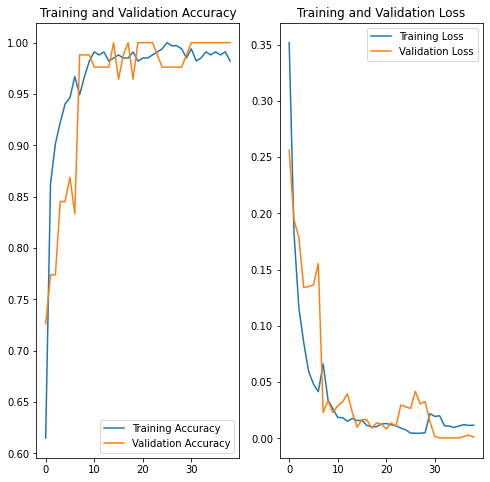

In [16]:
acc = []
val_acc = []
loss = []
val_loss = []
for history in histories:
    acc = acc + history.history['accuracy']
    val_acc = val_acc + history.history['val_accuracy']

    loss = loss + history.history['loss']
    val_loss = val_loss + history.history['val_loss']
    

epochs_range = range(len(acc))

pyplot.figure(figsize=(8, 8))
pyplot.subplot(1, 2, 1)
pyplot.plot(epochs_range, acc, label='Training Accuracy')
pyplot.plot(epochs_range, val_acc, label='Validation Accuracy')
pyplot.legend(loc='lower right')
pyplot.title('Training and Validation Accuracy')

pyplot.subplot(1, 2, 2)
pyplot.plot(epochs_range, loss, label='Training Loss')
pyplot.plot(epochs_range, val_loss, label='Validation Loss')
pyplot.legend(loc='upper right')
pyplot.title('Training and Validation Loss')
pyplot.show()

In [17]:
def to_type(one_hot_encoding):
    return sl.get_vocabulary()[np.argmax(tf.nn.softmax(one_hot_encoding))]

predictions = [ to_type(model.predict(X_test)[i]) for i in range(len(X_test)) ]
actuals = [ to_type(y_test[i]) for i in range(len(y_test)) ]

pd.DataFrame(np.array([actuals, predictions]).T, columns=["actual", "predicted"])

,actual,predicted
0,defacement,benign
1,defacement,defacement
2,benign,benign
3,benign,benign
4,benign,benign
5,defacement,benign
6,benign,benign
7,defacement,benign
8,benign,benign
9,defacement,defacement


In [18]:
def predict(url):
    one = download_one(url)
    if(one is None or one["status_code"] != 200):
        raise Exception("Failed to get data for this url")
    one = pd.DataFrame([one.values()], columns=list(one))
    one["redirects"] = one["redirects"].astype(str)
    one["latitude"] = one["latitude"].astype(str)
    one["longitude"] = one["longitude"].astype(str)
    return to_type(model.predict(one[feature_names]))

In [19]:
print(predict("https://cnn.com/"))
print(predict("https://google.com/"))

  0%|          | 0/275 [00:00<?, ?it/s]

benign


  0%|          | 0/17 [00:00<?, ?it/s]

benign
